In [1]:

import braidz_analysis
import importlib
importlib.reload(braidz_analysis)
from braidz_analysis import braidz, processing, trajectory

2024-12-16 11:24:40,229 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
root_folder = "/home/buchsbaum/mnt/nfc3008/md0/Experiments"
exp_list = [
    "20241213_143459.braidz",
]

combined_data = braidz.read_multiple_braidz(
    exp_list,
    root_folder=root_folder,
    parser="pyarrow"
)

2024-12-16 11:24:40,238 [INFO] Processing 1 files
2024-12-16 11:24:40,296 [INFO] Reading /home/buchsbaum/mnt/nfc3008/md0/Experiments/20241213_143459.braidz using pyarrow


Processing file 1/1: /home/buchsbaum/mnt/nfc3008/md0/Experiments/20241213_143459.braidz


2024-12-16 11:25:15,016 [WARNING] PyArrow parsing failed: Empty CSV file:<zipfile.ZipExtFile name='experiment_info.csv' mode='r'>, falling back to pandas
2024-12-16 11:25:15,017 [WARNING] Empty CSV file <zipfile.ZipExtFile name='experiment_info.csv' mode='r'> encountered
2024-12-16 11:25:15,344 [INFO] Combining processed data
2024-12-16 11:25:15,345 [INFO] Combined 1 kalman estimate dataframes
2024-12-16 11:25:15,345 [INFO] Combined 1 stimulus dataframes
2024-12-16 11:25:15,346 [INFO] Combined 1 optogenetics dataframes


In [3]:
data = processing.get_stim_or_opto_data(combined_data["df"], combined_data["opto"])

100%|██████████| 286/286 [00:02<00:00, 107.46it/s]


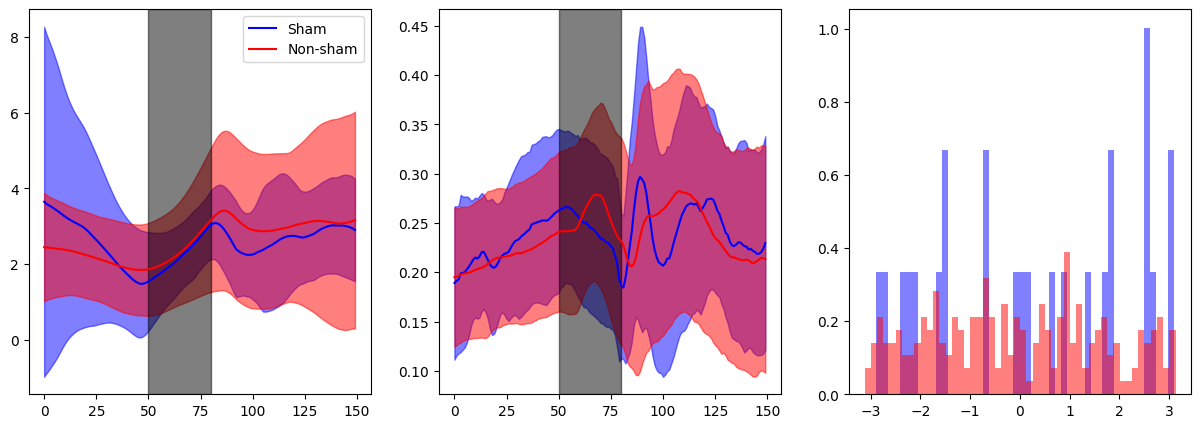

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

abs_angvel = np.abs(data["angular_velocity"])
sham_angvel = abs_angvel[data["sham"]]
non_sham_angvel = abs_angvel[~data["sham"]]

sham_linvel = data["linear_velocity"][data["sham"]]
non_sham_linvel = data["linear_velocity"][~data["sham"]]

sham_heading_diff = data["heading_diff"][data["sham"]]
non_sham_heading_diff = data["heading_diff"][~data["sham"]]

sham_angvel_mean, sham_angvel_std = np.nanmean(sham_angvel, axis=0), np.nanstd(sham_angvel, axis=0)
lines1 = axs[0].plot(sham_angvel_mean, color="blue", label="Sham")
axs[0].fill_between(np.arange(sham_angvel_mean.size), sham_angvel_mean - sham_angvel_std, sham_angvel_mean + sham_angvel_std, color="blue", alpha=0.5)

non_sham_angvel_mean, non_sham_angvel_std = np.nanmean(non_sham_angvel, axis=0), np.nanstd(non_sham_angvel, axis=0)
lines2 = axs[0].plot(non_sham_angvel_mean, color="red", label="Non-sham")
axs[0].fill_between(np.arange(non_sham_angvel_mean.size), non_sham_angvel_mean - non_sham_angvel_std, non_sham_angvel_mean + non_sham_angvel_std, color="red", alpha=0.5)

axs[0].axvspan(50, 80, color="black", alpha=0.5)
sham_linvel_mean, sham_linvel_std = np.nanmean(sham_linvel, axis=0), np.nanstd(sham_linvel, axis=0)
axs[1].plot(sham_linvel_mean, color="blue", label="Sham")
axs[1].fill_between(np.arange(sham_linvel_mean.size), sham_linvel_mean - sham_linvel_std, sham_linvel_mean + sham_linvel_std, color="blue", alpha=0.5)

non_sham_linvel_mean, non_sham_linvel_std = np.nanmean(non_sham_linvel, axis=0), np.nanstd(non_sham_linvel, axis=0)
axs[1].plot(non_sham_linvel_mean, color="red", label="Non-sham")
axs[1].fill_between(np.arange(non_sham_linvel_mean.size), non_sham_linvel_mean - non_sham_linvel_std, non_sham_linvel_mean + non_sham_linvel_std, color="red", alpha=0.5)
axs[1].axvspan(50, 80, color="black", alpha=0.5)
axs[2].hist(sham_heading_diff, bins=50, color="blue", alpha=0.5, label="Sham", density=True)
axs[2].hist(non_sham_heading_diff, bins=50, color="red", alpha=0.5, label="Non-sham", density=True)

axs[0].legend()
plt.show()

# Understanding the Data Structure

The `combined_data` dictionary contains structured data from braidz files with several key components:

## Key Components
- `df`: Contains the main `kalman_estimates` data (always present)
- `stim`: Contains stimulus-related data (if present)
- `opto`: Contains optogenetics data (if present)

Example of checking available keys:
```
print(f"Available data keys: {list(combined_data.keys())}")
```

## Data Structure
The main DataFrame (`combined_data['df']`) contains various measurements and tracking data. You can examine its structure:

```
# View all columns in the main DataFrame
columns = combined_data['df'].columns
print("Available columns:", columns.tolist())
```

## Working with Groups

The data is organized hierarchically using two main identifiers:
- `obj_id`: Unique identifier for each tracked object (can be the same across different experiments)
- `exp_num`: Experiment number for different recording sessions

### Grouping Patterns

1. Group by object:
```
object_groups = combined_data['df'].groupby('obj_id')
```

2. Group by experiment:
```
experiment_groups = combined_data['df'].groupby('exp_num')
```

3. Group by both (most common use case):
```
# This creates groups for each unique object within each experiment
obj_exp_groups = combined_data['df'].groupby(['obj_id', 'exp_num'])
```